In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.version

'3.8.12 | packaged by conda-forge | (default, Oct 12 2021, 21:59:51) \n[GCC 9.4.0]'

In [3]:
from cbf_opt import asif, cbf, dynamics
import numpy as np
import matplotlib.pyplot as plt

In [4]:
class ACC_Dynamics(dynamics.ControlAffineDynamics):
    def __init__(self, params, **kwargs):
        params['n_dims'] = 3
        params['control_dims'] = 1  # TODO: How to do this correctly?
        super().__init__(params, **kwargs)
        self.mass = params["mass"]
        self.g = params["g"]
        self.f0 = params["f0"]
        self.f1 = params["f1"]
        self.f2 = params["f2"]
        self.rolling_resistance = lambda x: self.f0 + self.f1 * x[1] + self.f2 * x[1] ** 2
        self.v0 = params["v0"]

    def open_loop_dynamics(self, state, time=None):
        return np.array([state[1], -1 / self.mass * self.rolling_resistance(state), self.v0 - state[1]])

    def control_jacobian(self, state, time=None):
        return np.expand_dims(np.array([0, 1 / self.mass, 0]), axis=-1)

In [5]:
class ACC_CBF(cbf.ControlAffineCBF):
    def __init__(self, dynamics, params, **kwargs):
        super().__init__(dynamics, params, **kwargs)
        self.Th = params["Th"]
        self.cd = params["cd"]

    def vf(self, state, time=None):
        return state[2] - self.Th * (state[1] - self.dynamics.v0) ** 2 / (2 * self.cd * self.dynamics.g)

    def vf_dt_partial(self, state, time=None):
        return 0.0
    
    def _grad_vf(self, state, time=None):
        return np.array([0.0, -self.Th * (state[1] - self.dynamics.v0) / (self.cd * self.dynamics.g), 1.0])

In [6]:
params = dict()
params["n_dims"] = 3
params["control_dims"] = 1
params["dt"] = 0.01
params["g"] = 9.81
params['v0'] = 14  # lead vehicle velocity
params['f0'] = 0.1  # friction coefficient
params['f1'] = 5  # friction coefficient
params['f2'] = 0.25  # friction coefficient
params['mass'] = 1650  # vehicle mass

acc = ACC_Dynamics(params)

In [7]:
cbf_params = dict()
cbf_params["cd"] = 0.3
cbf_params["Th"] = 1.8
acc_cbf = ACC_CBF(acc, cbf_params)

In [14]:
vd = 24
umax = cbf_params['cd'] * params['mass'] * params['g']
umin = -umax
alpha = lambda x: 5 * x
nominal_policy = lambda x, t: np.atleast_1d(np.clip(-1000 * (x[1] - vd), umin, umax))
acc_asif = asif.ControlAffineASIF(acc, acc_cbf, alpha=alpha, nominal_policy=nominal_policy, umin=umin, umax=umax)

beta0 = 0.0
penalty_coeff = 1e6

acc_gen_asif = asif.GeneralizedControlAffineASIF(acc, acc_cbf, beta0=beta0, penalty_coeff=penalty_coeff, alpha=alpha, nominal_policy=nominal_policy, verbose=False, umin=umin, umax=umax)


TODO: Make simulating dynamics much more straightforward -> See e.g. Dawson

In [15]:
x0 = np.array([0, 30, 100])
states = [x0]
control = []
control_filt = []
control_filt_gen = []
x_filt = x0 
betas = []
states_filt = [x0]
x_filt_gen = x0
states_filt_gen = [x0]

ts = np.arange(0, 10, params['dt'])

x = x0
for t in ts:  
    input_nom = nominal_policy(x, t)
    x = acc.step(x, input_nom)
    states.append(x)
    control.append(input_nom)

for t in ts:
    try:
        input_mod = np.atleast_1d(np.clip(acc_asif(x_filt), umin, umax))
    except:
        break

    x_filt = acc.step(x_filt, input_mod)
    states_filt.append(x_filt)
    control_filt.append(input_mod)

for t in ts:
    try:
        input = np.atleast_1d(np.clip(acc_gen_asif(x_filt_gen), umin, umax))
    except:
        acc_gen_asif = asif.GeneralizedControlAffineASIF(acc, acc_cbf, beta0=beta0, penalty_coeff=penalty_coeff, alpha=alpha, nominal_policy=nominal_policy, verbose=False, solver='ECOS')
        input = np.atleast_1d(np.clip(acc_gen_asif(x_filt_gen), umin, umax))
    betas.append(acc_gen_asif.get_beta())
    x_filt_gen = acc.step(x_filt_gen, input)
    states_filt_gen.append(x_filt_gen)
    control_filt_gen.append(input)


/home/tonkens/anaconda3/envs/cbf_hjr/lib/python3.8/site-packages/cvxpy/problems/problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


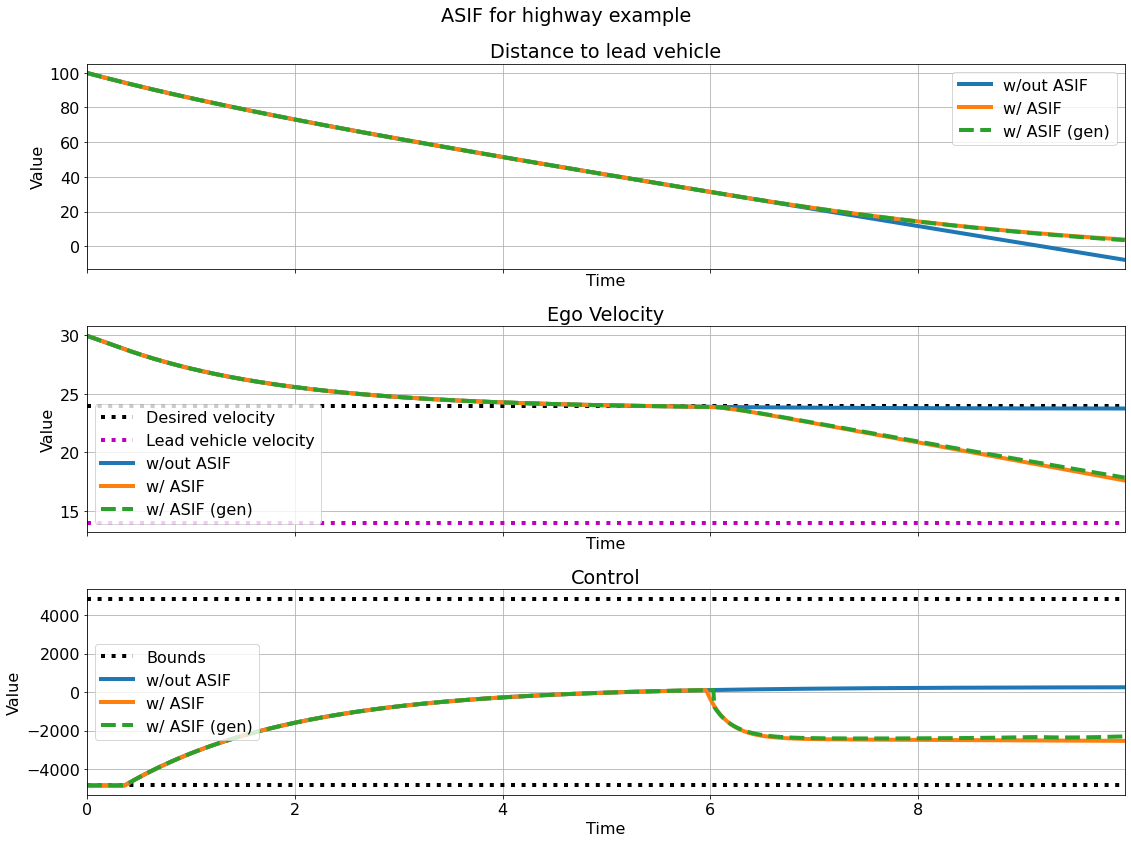

In [16]:
states = np.array(states)
states_filt = np.array(states_filt)
states_filt_gen = np.array(states_filt_gen)

ts = np.arange(0, 10, params['dt'])
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(16, 12))
plt.rcParams['font.size'] = '16'
plt.rcParams['lines.linewidth'] = 4
fig.suptitle("ASIF for highway example")
ax[0].set_title("Distance to lead vehicle")
ax[0].plot(ts[:states.shape[0]-1], states[1:,2], label='w/out ASIF')
ax[0].plot(ts[:states_filt.shape[0]-1], states_filt[1:,2], label='w/ ASIF')
ax[0].plot(ts[:states_filt_gen.shape[0]-1], states_filt_gen[1:,2], '--', label='w/ ASIF (gen)')

ax[0].legend()
ax[1].set_title("Ego Velocity")
ax[1].plot(ts, vd * np.ones_like(ts), ':k', label='Desired velocity')
ax[1].plot(ts, params['v0'] * np.ones_like(ts), ':m', label='Lead vehicle velocity')
ax[1].plot(ts[:states.shape[0]-1], states[1:,1], label='w/out ASIF')
ax[1].plot(ts[:states_filt.shape[0]-1], states_filt[1:,1], label='w/ ASIF')
ax[1].plot(ts[:states_filt_gen.shape[0]-1], states_filt_gen[1:,1], '--', label='w/ ASIF (gen)')

ax[1].legend()
ax[2].set_title("Control")
ax[2].plot(ts, np.ones_like(ts) * umax, ':k', label='Bounds')
ax[2].plot(ts, np.ones_like(ts) * umin, ':k', label='__nolegend__')
ax[2].plot(ts[:len(control)], control, label='w/out ASIF')
ax[2].plot(ts[:len(control_filt)], control_filt, label='w/ ASIF')
ax[2].plot(ts[:len(control_filt_gen)], control_filt_gen, '--', label='w/ ASIF (gen)')

ax[2].legend()
for axi in ax:
    axi.grid()
    axi.set_xlabel("Time")
    axi.set_ylabel("Value")
    axi.set_xlim([ts[0], ts[-1]])
fig.tight_layout()
